In [1]:
import matplotlib.pyplot as plt
import numpy

from ipywidgets import IntSlider, interact
from typing import Iterator, Tuple

In [2]:
class ELM:
    n_rows: int
    n_cols: int
    displacement: numpy.ndarray
    velocity: numpy.ndarray
    force: numpy.ndarray

    # K
    elastic_spring_constant: float
    # c
    bond_bending_constant: float
    
    def make(n_rows: int, n_cols: int):
        return ELM(
            n_rows,
            n_cols,
            numpy.zeros((n_rows, n_cols, 2)),
            numpy.zeros((n_rows, n_cols, 2)),
            numpy.zeros((n_rows, n_cols, 2))
        )
    
    def __init__(
        self,
        n_rows: int,
        n_cols: int,
        displacement: numpy.ndarray,
        velocity: numpy.ndarray,
        force: numpy.ndarray
    ) -> None:
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.displacement = displacement
        self.velocity = velocity
        self.force = force

        self.elastic_spring_constant = 1.0
        self.bond_bending_constant = 2.0
    
    # u_i(t)
    def get_displacement(self, row: int, col: int) -> numpy.ndarray:
        return self.displacement[row, col, :]

    def set_displacement(self, row: int, col: int, displacement: numpy.ndarray) -> None:
        self.displacement[row, col, :] = displacement

    # x_i(t)
    def get_lattice_position(self, row: int, col: int) -> numpy.ndarray:
        return numpy.array([col, row], dtype=float)

    # r_i(t)
    def get_actual_position(self, row: int, col: int) -> numpy.ndarray:
        return self.get_lattice_position(row, col) + self.get_displacement(row, col)
        
    # v_i(t)
    def get_velocity(self, row: int, col: int) -> numpy.ndarray:
        return self.velocity[row, col, :]

    # F_i(t)
    def get_force(self, row: int, col: int) -> numpy.ndarray:
        return self.force[row, col, :]

    def set_force(self, row: int, col: int, force: numpy.ndarray) -> None:
        self.force[row, col, :] = force

(O'Brien, 2008)

The force acting on node $i$ is given by

$$
\mathbf{F}_i = \sum^N_j \mathbf{F}_{ij} \frac{\mathbf{r}_{ij}}{|\mathbf{r}_{ij}|}
$$

Where $N = 8$ (for the 2D case) is the number of neighbors $j$.
The force $\mathbf{F}_{ij}$ on node $i$ from node $j$ is given by

$$
\mathbf{F}_{ij} = -K_{ij} (\mathbf{u}_{ij} \cdot \mathbf{x}_{ij}) + \frac{c \mathbf{u}_{ij}}{|\mathbf{x}_{ij}|^2}
$$

where

* $K_{ij} \in \mathbb{R}$ is the elastic spring constant
* $\mathbf{u}_{ij} = \mathbf{u}_i - \mathbf{u}_j \in \mathbb{R}^2$ is the displacement
* $\mathbf{x}_{ij} = \mathbf{x}_i - \mathbf{x}_j \in \mathbb{R}^2$ is the vector connecting nodes $i$ and $j$ on the undistorted lattice
* $c \in \mathbb{R}$ is the bond-bending constant

The $\frac{c \mathbf{u}_{ij}}{|\mathbf{x}_{ij}|^2}$ part does not make sense to me since the first summand in $\mathbf{F}_{ij}$ is scalar so the implementation below leaves it out.

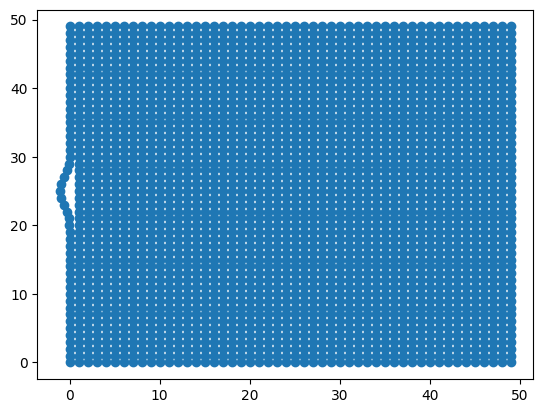

In [3]:
def neighbors(elm: ELM, row: int, col: int) -> Iterator[Tuple[float, int, int]]:
    for row_offset in [-1, 0, 1]:
        for col_offset in [-1, 0, 1]:
            nb_row = row + row_offset
            nb_col = col + col_offset
            
            if nb_row < 0 or nb_row >= elm.n_rows or nb_col < 0 or nb_col >= elm.n_cols:
                continue
            if row_offset == 0 and col_offset == 0:
                continue
            
            k = 1.0 if row_offset == 0 or col_offset == 0 else 2.0
            yield (k, nb_row, nb_col)

def calculate_force(elm: ELM, displacement: numpy.ndarray, row: int, col: int) -> numpy.ndarray:
    K = elm.elastic_spring_constant
    c = elm.bond_bending_constant

    total = numpy.array([0.0, 0.0])
    for k, nb_row, nb_col in neighbors(elm, row, col):
        u_ij = displacement[row, col, :] - displacement[nb_row, nb_col, :]
        x_ij = elm.get_lattice_position(row, col) - elm.get_lattice_position(nb_row, nb_col)
        r_ij = x_ij + u_ij
        
        total -= K * k * numpy.dot(u_ij, x_ij) * (r_ij / numpy.linalg.norm(r_ij)) + (c * u_ij) / (numpy.linalg.norm(x_ij) ** 2)

    return total

def gaussian(mu, sigma_sq, x):
    return numpy.exp(-(((x - mu) / numpy.sqrt(sigma_sq)) ** 2) / 2) / numpy.sqrt(2 * numpy.pi * sigma_sq)

e = ELM.make(50, 50)
n_plucked = 10
base = e.n_rows // 2 - n_plucked // 2
for row in range(n_plucked):
    e.set_displacement(base + row, 0, numpy.array([
        gaussian(n_plucked // 2, n_plucked / 3, row) * -5,
        0.0
    ]))

x, y = numpy.meshgrid(
    numpy.linspace(0, e.n_rows - 1, e.n_rows, dtype=int),
    numpy.linspace(0, e.n_cols - 1, e.n_cols, dtype=int)
)

plt.scatter(
    x + e.displacement[:, :, 0],
    y + e.displacement[:, :, 1]
)
plt.show()

A [velocity Verlet integration](https://en.wikipedia.org/wiki/Verlet_integration#Velocity_Verlet) scheme is used to solve the system.

Our initial configuration defines for each of the $M$ nodes $i$:

* $\mathbf{u}_i(t_0) \in \mathbb{R}^M \times 2$: Displacement
* $\mathbf{v}_i(t_0) \in \mathbb{R}^M \times 2$: Velocity

To calculate a time step, do for every node $i$:

* Calculate the displacement $\mathbf{u}_i(t + \Delta t) = \mathbf{u}_i(t) + \mathbf{v}_i(t) \Delta t + \frac{1}{2} \mathbf{F}_i(t) \Delta t^2$
* Calculate $\mathbf{F}_i(t + \Delta t)$ using $\mathbf{u}_i(t + \Delta t)$
* Calculate $\mathbf{v}_i(t + \Delta t) = \mathbf{v}_i(t) + \frac{1}{2} (\mathbf{F}_i(t) + \mathbf{F}_i(t + \Delta t)) \Delta t$

In [4]:
def velocity_verlet_step(elm: ELM, delta_t: float) -> ELM:
    new_displacement = elm.displacement + elm.velocity * delta_t + 0.5 * elm.force * delta_t * delta_t
    
    new_force = numpy.zeros((elm.n_rows, elm.n_cols, 2))
    for row in range(elm.n_rows):
        for col in range(elm.n_cols):
            new_force[row, col, :] = calculate_force(
                elm,
                new_displacement,
                row,
                col
            )
    
    new_velocity = elm.velocity + 0.5 * (elm.force + new_force) * delta_t

    return ELM(elm.n_rows, elm.n_cols, new_displacement, new_velocity, new_force)

In [5]:
es = [e]
for _ in range(300):
    print(".", end="")
    es.append(velocity_verlet_step(es[-1], 0.1))

............................................................................................................................................................................................................................................................................................................

In [6]:
def do_plot(i: int) -> None:
    fig, ax = plt.subplots(figsize=(10, 5), ncols=2)
    ax[0].scatter(
        x + es[i].displacement[:, :, 0],
        y + es[i].displacement[:, :, 1]
    )
    ax[0].quiver(
        x + es[i].displacement[:, :, 0],
        y + es[i].displacement[:, :, 1],
        es[i].force[:, :, 0],
        es[i].force[:, :, 1],
        angles = "xy",
        scale = 100
    )
    ax[1].imshow(numpy.linalg.norm(es[i].displacement, axis=2), cmap="hot")
    plt.show()

interact(do_plot, i = IntSlider(min=0, max=len(es) - 1, value=0))

interactive(children=(IntSlider(value=0, description='i', max=300), Output()), _dom_classes=('widget-interact'…

<function __main__.do_plot(i: int) -> None>

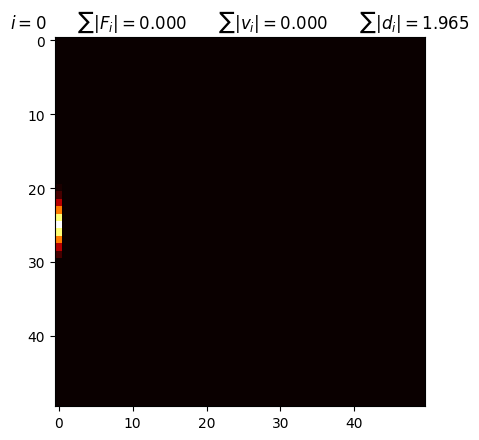

In [41]:
import matplotlib.animation as animation

fps = 60

fig, ax = plt.subplots(1, 1)
im = plt.imshow(numpy.linalg.norm(es[0].displacement, axis=2), cmap="hot")

def frame(i):
    im.set_data(numpy.linalg.norm(es[i].displacement, axis=2))
    im.autoscale()
    ax.set_title(f"$i = {i} \qquad \sum |F_i| = {numpy.sum(numpy.linalg.norm(es[i].force)):.3f} \qquad \sum |v_i| = {numpy.sum(numpy.linalg.norm(es[i].velocity)):.3f} \qquad \sum |d_i| = {numpy.sum(numpy.linalg.norm(es[i].displacement)):.3f}$")
    return [im]

anim = animation.FuncAnimation(
    fig,
    frame, 
    frames = len(es),
    interval = 1000 / fps,
)

In [42]:
anim.save('elastic.mp4', fps=fps)